In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_path = "Data/ai4i2020.csv"
df = pd.read_csv(data_path)

In [3]:
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


- Convert numeric columns to numeric dtype

In [4]:
num_cols = ["Air temperature [K]", "Process temperature [K]", 
            "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]"]

for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

print("✅ Numeric columns converted to numeric dtype")
print(df[num_cols].dtypes)

✅ Numeric columns converted to numeric dtype
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
dtype: object


- Create binary target column (failure)

In [5]:
if "Machine failure" in df.columns:
    df["failure"] = df["Machine failure"].astype(int)
elif "failure" in df.columns:
    df["failure"] = df["failure"].astype(int)
else:
    raise ValueError("⚠️ Could not find a failure column (Machine failure)")

print("✅ Created failure column")
print(df[["Machine failure","failure"]].head())


✅ Created failure column
   Machine failure  failure
0                0        0
1                0        0
2                0        0
3                0        0
4                0        0


- Derive failure type column

In [7]:
ft_cols = [c for c in ["TWF","HDF","PWF","OSF","RNF"] if c in df.columns]

if ft_cols:
    def get_failure_type(row):
        if row["failure"] != 1:
            return np.nan
        for k in ft_cols:
            if row[k] == 1:
                return k
        return "UNKNOWN"
    df["failure_type"] = df.apply(get_failure_type, axis=1)
    print("✅ Created failure_type column")
else:
    df["failure_type"] = np.nan
    print("⚠️ No failure type columns found")

print(df[["failure","failure_type"]].head())


✅ Created failure_type column
   failure failure_type
0        0          NaN
1        0          NaN
2        0          NaN
3        0          NaN
4        0          NaN


In [8]:
df.isnull().sum()

UDI                           0
Product ID                    0
Type                          0
Air temperature [K]           0
Process temperature [K]       0
Rotational speed [rpm]        0
Torque [Nm]                   0
Tool wear [min]               0
Machine failure               0
TWF                           0
HDF                           0
PWF                           0
OSF                           0
RNF                           0
failure                       0
failure_type               9661
dtype: int64

# Train/Test Split (Model 1 – Failure Prediction)

In [9]:
from sklearn.model_selection import train_test_split

# Feature columns (use your exact column names)
feature_cols = ["Air temperature [K]", "Process temperature [K]",
                "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]"]

X = df[feature_cols].copy()
y = df["failure"].astype(int).copy()

# Stratified split to keep the same failure ratio in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train positive rate:", y_train.mean().round(4),
      "| y_test positive rate:", y_test.mean().round(4))


X_train: (7500, 5) X_test: (2500, 5)
y_train positive rate: 0.0339 | y_test positive rate: 0.034


# Train a baseline model (Logistic Regression)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, average_precision_score

# 1) Create and fit a baseline Logistic Regression
logreg = LogisticRegression(max_iter=5000, class_weight="balanced", solver="lbfgs")
logreg.fit(X_train, y_train)

# 2) Predict labels and probabilities on the test set
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:, 1]

# 3) Print a focused report (especially class '1' = failure)
print("=== Logistic Regression (baseline) ===")
print(classification_report(y_test, y_pred, digits=4))

# 4) Average Precision (area under Precision–Recall curve)
ap = average_precision_score(y_test, y_proba)
print(f"Average Precision (AP): {ap:.4f}")


=== Logistic Regression (baseline) ===
              precision    recall  f1-score   support

           0     0.9915    0.8203    0.8978      2415
           1     0.1355    0.8000    0.2317        85

    accuracy                         0.8196      2500
   macro avg     0.5635    0.8101    0.5647      2500
weighted avg     0.9624    0.8196    0.8752      2500

Average Precision (AP): 0.4070


# Precision–Recall Curve (for Logistic Regression)

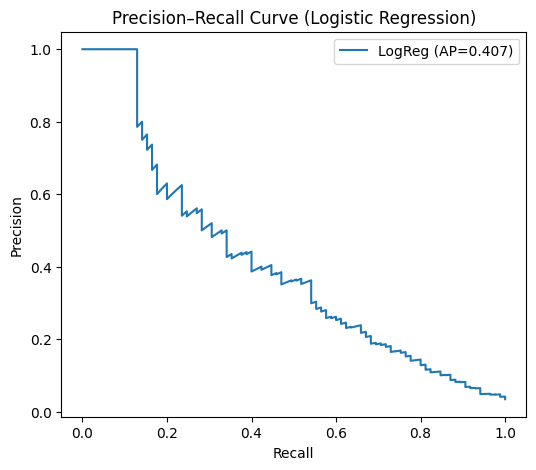

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Calculate curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Plot
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"LogReg (AP={ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Logistic Regression)")
plt.legend()
plt.show()


# Random Forest Classifier

In [12]:
from sklearn.ensemble import RandomForestClassifier

# 1) Create and fit Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight="balanced",
    random_state=42
)
rf.fit(X_train, y_train)

# 2) Predictions
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# 3) Report
print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf, digits=4))

# 4) Average Precision
ap_rf = average_precision_score(y_test, y_proba_rf)
print(f"Average Precision (AP): {ap_rf:.4f}")


=== Random Forest ===
              precision    recall  f1-score   support

           0     0.9841    0.9971    0.9905      2415
           1     0.8679    0.5412    0.6667        85

    accuracy                         0.9816      2500
   macro avg     0.9260    0.7691    0.8286      2500
weighted avg     0.9801    0.9816    0.9795      2500

Average Precision (AP): 0.7643


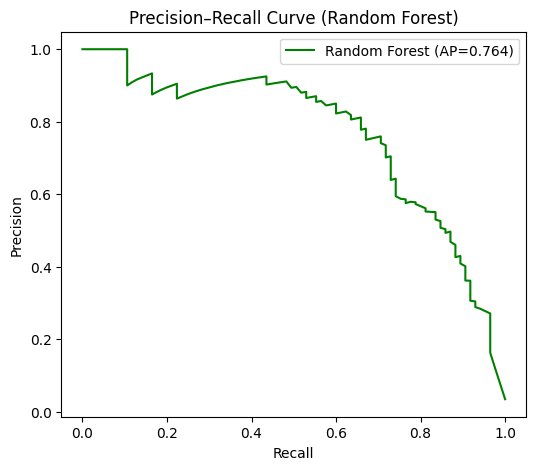

In [13]:
# Calculate precision-recall curve
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, y_proba_rf)

# Plot
plt.figure(figsize=(6,5))
plt.plot(recall_rf, precision_rf, label=f"Random Forest (AP={ap_rf:.3f})", color="green")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Random Forest)")
plt.legend()
plt.show()


In [14]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, average_precision_score

# 1) Create and fit Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

# 2) Predictions
y_pred_gb = gb.predict(X_test)
# decision_function not available; use predict_proba
y_proba_gb = gb.predict_proba(X_test)[:, 1]

# 3) Report
print("=== Gradient Boosting ===")
print(classification_report(y_test, y_pred_gb, digits=4))

# 4) Average Precision (PR AUC)
ap_gb = average_precision_score(y_test, y_proba_gb)
print(f"Average Precision (AP): {ap_gb:.4f}")


=== Gradient Boosting ===
              precision    recall  f1-score   support

           0     0.9877    0.9971    0.9924      2415
           1     0.8871    0.6471    0.7483        85

    accuracy                         0.9852      2500
   macro avg     0.9374    0.8221    0.8703      2500
weighted avg     0.9843    0.9852    0.9841      2500

Average Precision (AP): 0.7945


# Calculate precision-recall curve

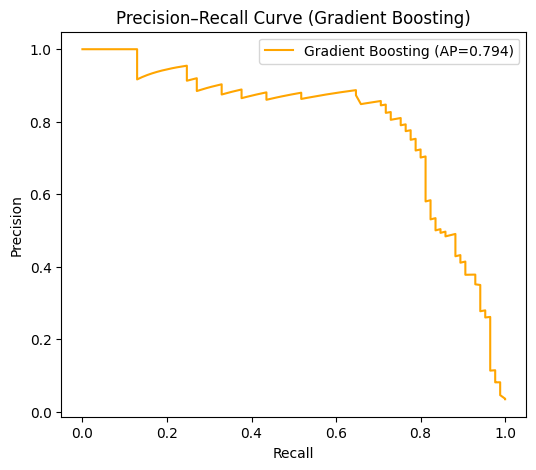

In [15]:

precision_gb, recall_gb, thresholds_gb = precision_recall_curve(y_test, y_proba_gb)

# Plot
plt.figure(figsize=(6,5))
plt.plot(recall_gb, precision_gb, label=f"Gradient Boosting (AP={ap_gb:.3f})", color="orange")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Gradient Boosting)")
plt.legend()
plt.show()


In [16]:
from sklearn.model_selection import train_test_split

# 1) Keep only rows where failure = 1 and failure_type is known
df_fail = df[(df["failure"] == 1) & (df["failure_type"].notna())].copy()

# 2) Encode failure_type as labels
labels = sorted(df_fail["failure_type"].unique())
label2id = {lab: i for i, lab in enumerate(labels)}
id2label = {i: lab for lab, i in label2id.items()}

y2 = df_fail["failure_type"].map(label2id).values
X2 = df_fail[["Air temperature [K]", "Process temperature [K]",
              "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]"]].values

# 3) Train/Test split
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.25, random_state=42, stratify=y2
)

print("X2_train:", X2_train.shape, "X2_test:", X2_test.shape)
print("Unique failure types:", labels)


X2_train: (254, 5) X2_test: (85, 5)
Unique failure types: ['HDF', 'OSF', 'PWF', 'TWF', 'UNKNOWN']


In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1) Create and fit Decision Tree
dt = DecisionTreeClassifier(max_depth=None, random_state=42)
dt.fit(X2_train, y2_train)

# 2) Predictions
y2_pred_dt = dt.predict(X2_test)

# 3) Report
print("=== Decision Tree ===")
print(classification_report(y2_test, y2_pred_dt, target_names=labels, digits=4))

# 4) Confusion Matrix
cm_dt = confusion_matrix(y2_test, y2_pred_dt)
print("Confusion Matrix:\n", cm_dt)


=== Decision Tree ===
              precision    recall  f1-score   support

         HDF     0.8286    1.0000    0.9062        29
         OSF     0.8571    0.6000    0.7059        20
         PWF     0.8519    1.0000    0.9200        23
         TWF     0.8750    0.6364    0.7368        11
     UNKNOWN     0.0000    0.0000    0.0000         2

    accuracy                         0.8353        85
   macro avg     0.6825    0.6473    0.6538        85
weighted avg     0.8281    0.8353    0.8196        85

Confusion Matrix:
 [[29  0  0  0  0]
 [ 4 12  2  1  1]
 [ 0  0 23  0  0]
 [ 2  2  0  7  0]
 [ 0  0  2  0  0]]


In [18]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# 1) Create pipeline with scaling + SVM (RBF kernel)
svm_model = make_pipeline(StandardScaler(), SVC(kernel="rbf", random_state=42))

# 2) Fit model
svm_model.fit(X2_train, y2_train)

# 3) Predictions
y2_pred_svm = svm_model.predict(X2_test)

# 4) Report
print("=== SVM (RBF) ===")
print(classification_report(y2_test, y2_pred_svm, target_names=labels, digits=4))

# 5) Confusion Matrix
cm_svm = confusion_matrix(y2_test, y2_pred_svm)
print("Confusion Matrix:\n", cm_svm)


=== SVM (RBF) ===
              precision    recall  f1-score   support

         HDF     0.8056    1.0000    0.8923        29
         OSF     0.6923    0.9000    0.7826        20
         PWF     1.0000    0.6957    0.8205        23
         TWF     1.0000    0.6364    0.7778        11
     UNKNOWN     0.0000    0.0000    0.0000         2

    accuracy                         0.8235        85
   macro avg     0.6996    0.6464    0.6546        85
weighted avg     0.8377    0.8235    0.8113        85

Confusion Matrix:
 [[29  0  0  0  0]
 [ 2 18  0  0  0]
 [ 3  4 16  0  0]
 [ 0  4  0  7  0]
 [ 2  0  0  0  0]]


C:\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [19]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix

# Train
nb = GaussianNB()
nb.fit(X2_train, y2_train)

# Predict
y2_pred_nb = nb.predict(X2_test)

# Report
print("=== Naive Bayes (GaussianNB) ===")
print(classification_report(y2_test, y2_pred_nb, target_names=labels,
                            digits=4, zero_division=0))

# Confusion Matrix
cm_nb = confusion_matrix(y2_test, y2_pred_nb, labels=list(range(len(labels))))
print("Confusion Matrix:\n", cm_nb)


=== Naive Bayes (GaussianNB) ===
              precision    recall  f1-score   support

         HDF     0.7000    0.9655    0.8116        29
         OSF     0.6087    0.7000    0.6512        20
         PWF     1.0000    0.6087    0.7568        23
         TWF     0.7500    0.5455    0.6316        11
     UNKNOWN     0.0000    0.0000    0.0000         2

    accuracy                         0.7294        85
   macro avg     0.6117    0.5639    0.5702        85
weighted avg     0.7497    0.7294    0.7166        85

Confusion Matrix:
 [[28  1  0  0  0]
 [ 4 14  0  2  0]
 [ 6  3 14  0  0]
 [ 0  5  0  6  0]
 [ 2  0  0  0  0]]
